In [1]:
# Tensorflow 1.15.0

import csv
import datetime
import math
import multiprocessing as mp
import numpy as np
import pandas as pd
import os
import random
import sys
import tensorflow as tf
import time
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt


c:\Users\lunar\anaconda3\envs\project\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [71]:
data = pd.read_excel('Updated_Data_0530.xlsx')
data.head()

,Date,MSCI_AC,선진국,신흥국,에너지외,금,달러,대체,안전채권,하이일드
0,1999-12-31,341.63,1420.89,489.42,86.3081,168.6074,101.87,1000.00,213.5597,307.3555
1,2000-01-02,341.63,1420.89,489.42,86.3081,168.6074,101.87,1000.00,213.5597,307.3555
2,2000-01-03,342.16,1422.18,496.22,86.3081,168.6074,100.22,1019.92,214.3113,306.5419
3,2000-01-04,332.30,1378.31,500.38,85.3345,165.1724,100.41,997.64,214.7857,306.0794
4,2000-01-05,327.68,1359.54,491.09,83.7461,164.2408,100.38,971.24,214.3650,305.7534


In [18]:
data = pd.read_excel('Updated_Data_0530.xlsx')
data.columns = ['Date', "MSCI_AC", "Advanced countries", " Emerging countries", "Non-Energy", "Gold", "Dollar", "Alternate", "Safety Bond", "Hyield"]
ticker = ["MSCI_AC", "Advanced countries", " Emerging countries", "Non-Energy", "Gold", "Dollar", "Alternate", "Safety Bond", "Hyield"]
df = pd.DataFrame()
for i in range(len(ticker)):
    tmp = pd.DataFrame({
        'date': np.ravel(np.array(data[['Date']], dtype='datetime64[D]'))[1:],
        'ticker':np.ravel(np.full((1,len(data.index)), ticker[i]))[1:],
        'price':np.ravel(np.array(data[[ticker[0]]].pct_change()[1:]))
    })
    df = pd.concat([df, tmp])

df.to_csv('prices.csv')

In [19]:
from urllib.request import urlretrieve
from os.path import isfile, isdir

CSV_URL = 'SEE_PREPROCESSING_NOTEBOOK'
FILE_NAME = 'prices.csv'
LOG_DIR = 'output'
MODEL_PATH = os.path.join(LOG_DIR, "model.ckpt")
STOCK_PATH = os.path.join(LOG_DIR,'stock.tsv')

if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

if not os.path.exists('input'):
    os.makedirs('input')

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(FILE_NAME):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Prices') as pbar:
        urlretrieve(CSV_URL, FILE_NAME, pbar.hook)

In [20]:
chunksize = 1000000
price_rows = 73647

price_reader = pd.read_csv(FILE_NAME, 
                      header=None,
                      parse_dates=[1],
                      chunksize=chunksize, 
                      iterator=True)
df_prices = pd.DataFrame()

with tqdm(total=price_rows, desc='rows') as pbar:
    for chunk in price_reader:
        df_prices = df_prices.append(chunk)
        pbar.update(chunksize);

df_prices.columns = ['index','date', 'ticker', 'price']

# Sort by date, then ticker
df_prices.sort_values(['date','ticker'], inplace=True)
df_prices = df_prices[:-1]

prices = df_prices['price'].values.tolist()
dates = df_prices['date'].values.tolist()
tickers = df_prices['ticker'].values.tolist()

rows: 1000000it [00:00, 18486638.49it/s]       


In [21]:
ticker_to_int = {}
int_to_ticker = {}

def get_ticker_int(idx):
    ticker = tickers[idx]
    key = ticker_to_int.get(ticker, None)
    if key is None:
        key = ticker_to_int[ticker] = len(ticker_to_int)
        int_to_ticker[key] = ticker
    return key

def get_window(idx, total, window_size=5):
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R if (idx + R) < total else total

    stock_int = get_ticker_int(idx)
    stock_date = dates[idx]
    
    window = [] 
    
    for i in range(start, stop):
        nearby_stock_int = get_ticker_int(i)
        nearby_stock_date = dates[i]
        if nearby_stock_int != stock_int and nearby_stock_date == stock_date:
            window.append(nearby_stock_int)
    
    return window

for idx in range(0, 20, 9):
    print('window for', idx, tickers[idx], get_ticker_int(idx))
    for nearby_int in get_window(idx, len(tickers), 5):
        print(nearby_int, int_to_ticker[nearby_int])

window for 0  Emerging countries 0
window for 9  Emerging countries 0
window for 18  Emerging countries 0
4 Advanced countries
5 Alternate


In [22]:
batch_size = 10000
window_size = 10

total_prices = len(prices)

pbar = tqdm(total=int(total_prices / batch_size))

def get_batch(start):
    x, y = [], []

    stop = start + batch_size if (start + batch_size) < total_prices else total_prices

    for i in range(start, stop):
        batch_x = get_ticker_int(i)
        batch_y = get_window(i, total_prices, window_size)
        y.extend(batch_y)
        x.extend([batch_x]*len(batch_y))

    pbar.update();

    return [x, y]

def get_batches():
    batches = []
    
    for start in range(0, total_prices, batch_size):
        batches.append(get_batch(start))
   
    return batches

batches = get_batches()

 86%|████████▌ | 6/7 [00:00<00:00, 14.27it/s]

In [23]:

# Save embedding metadata
with open(STOCK_PATH, 'w') as out:
  out.write('\n'.join(int_to_ticker.values()))

In [24]:
n_embedding = 50 # Number of embedding features 
n_stocks = len(df_prices['ticker'].unique())

train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.compat.v1.placeholder(tf.int32, [None], name='inputs')
    labels = tf.compat.v1.placeholder(tf.int32, [None, None], name='labels')
    embedding = tf.Variable(tf.random_uniform((n_stocks, n_embedding), -1, 1), name='stock_embedding')
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [25]:
# Number of negative labels to sample
n_sampled = 2


with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_stocks, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_stocks))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_stocks)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 1 # Random set of words to evaluate similarity on.
    valid_window = 2
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))



Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [26]:
epochs = 100

with train_graph.as_default():
    saver = tf.compat.v1.train.Saver()

with tf.compat.v1.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.compat.v1.global_variables_initializer())

    for e in range(1, epochs+1):
        start = time.time()
        for batch in batches:
            x = batch[0]
            y = batch[1]

            feed = {inputs: x, labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
    
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 10000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_stock = int_to_ticker[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_stock
                    for k in range(top_k):
                        try:
                            close_stock = int_to_ticker[nearest[k]]
                            log = '%s %s,' % (log, close_stock)
                        except Exception:
                            print('nearest[k]', nearest[k])
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, MODEL_PATH)
    embed_mat = sess.run(normalized_embedding)

Epoch 13/100 Iteration: 100 Avg. Training loss: 0.8433 0.0014 sec/batch
Epoch 25/100 Iteration: 200 Avg. Training loss: 0.8153 0.0026 sec/batch
Epoch 38/100 Iteration: 300 Avg. Training loss: 0.7830 0.0014 sec/batch


8it [00:15, 14.27it/s]                       

Epoch 50/100 Iteration: 400 Avg. Training loss: 0.7763 0.0027 sec/batch
Epoch 63/100 Iteration: 500 Avg. Training loss: 0.7785 0.0015 sec/batch
Epoch 75/100 Iteration: 600 Avg. Training loss: 0.7848 0.0028 sec/batch
Epoch 88/100 Iteration: 700 Avg. Training loss: 0.7102 0.0015 sec/batch
Epoch 100/100 Iteration: 800 Avg. Training loss: 0.7721 0.0028 sec/batch


In [30]:
# Save the embedding for tensorboard
from tensorboard.plugins import projector

with train_graph.as_default():
    saver = tf.compat.v1.train.Saver()

with tf.compat.v1.Session(graph=train_graph) as sess:
    saver.restore(sess, MODEL_PATH)
    
    config = projector.ProjectorConfig()

    viz_embedding = config.embeddings.add()
    viz_embedding.tensor_name = embedding.name
    viz_embedding.metadata_path = STOCK_PATH
    summary_writer = tf.compat.v1.summary.FileWriter(LOG_DIR)
    projector.visualize_embeddings(summary_writer, config)

    saver.save(sess, MODEL_PATH)

INFO:tensorflow:Restoring parameters from output\model.ckpt


In [47]:
from sklearn.manifold import TSNE

viz_stocks = 9
tsne = TSNE(n_components=2)
embed_tsne = tsne.fit_transform(embed_mat[:viz_stocks, :])

c:\Users\lunar\anaconda3\envs\project\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\lunar\anaconda3\envs\project\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


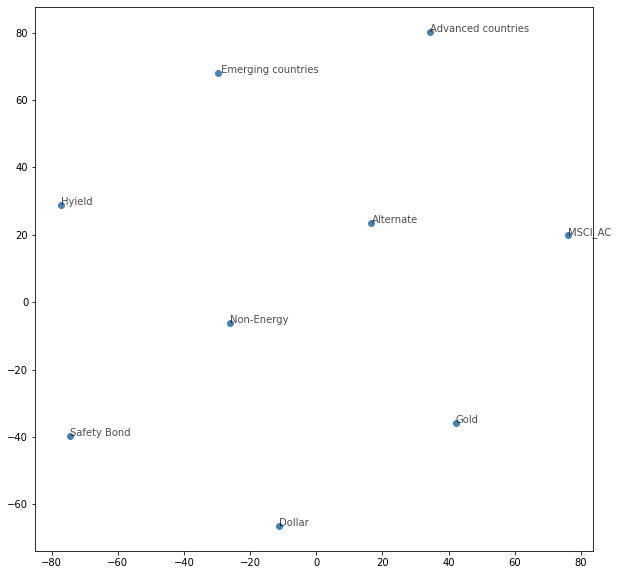

In [48]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
for idx in range(viz_stocks):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_ticker[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
plt.show()

In [49]:
tsne = TSNE(n_components=3)
embed_tsne = tsne.fit_transform(embed_mat[:viz_stocks, :])

c:\Users\lunar\anaconda3\envs\project\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\lunar\anaconda3\envs\project\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


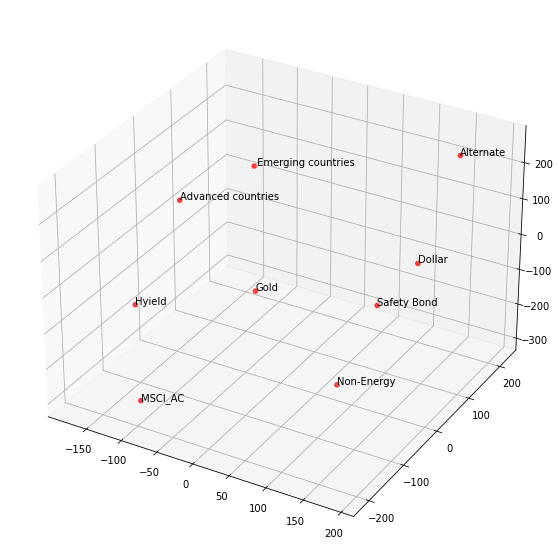

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = embed_tsne[:,0]
y = embed_tsne[:,1]
z = embed_tsne[:,2]

ax.scatter(x,y,z, color = 'r', alpha = 0.7)
for idx in range(viz_stocks):
    ax.text(x[idx],y[idx],z[idx], int_to_ticker[idx])
